# Анализ рисков ДТП

## Подключение к базе данных. Загрузка SQL-таблиц

In [1]:
# установка дополнительных пакетов
!pip install skfeature-chappers
!pip install optuna

     |████████████████████████████████| 66 kB 1.2 MB/s eta 0:00:01


In [2]:
import datetime
import re
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.metrics import roc_auc_score, plot_confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold, 
    StratifiedShuffleSplit, 
    train_test_split
)

from skfeature.function.similarity_based import fisher_score

from catboost import CatBoostClassifier, cv, Pool

In [3]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED=123

In [4]:
# подключение к базе данных
# параметры для подключения к БД скрыты в соответствии с офертой Яндекс.Практикума
db_config = {
'user': '', 
'pwd': '',
'host': '',
'port': ,
'db': '' 
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# создание подключения
engine = create_engine(connection_string) 

In [6]:
# создание pandas-датафрейма
# общая информация о ДТП
query_collisions = '''
SELECT *
FROM collisions;
'''

collisions_df = pd.read_sql_query(query_collisions, con=engine) 

In [7]:
# создание pandas-датафрейма
# информация об участниках ДТП
query_parties = '''
SELECT *
FROM parties;
'''

parties_df = pd.read_sql_query(query_parties, con=engine)

In [8]:
# создание pandas-датафрейма
# информация о пострадавших машинах
query_vehicles = '''
SELECT *
FROM vehicles;
'''

vehicles_df = pd.read_sql_query(query_vehicles, con=engine)

**Вывод:** создано подключение к базе данных и загружены таблицы с историческими данными о ДТП.

## Первичное исследование таблиц

**Краткое описание таблиц:**
- `collisions` — общая информация о ДТП. Имеет уникальный case_id. Таблица описывает общую информацию о ДТП. Например, где оно произошло и когда;
- `parties` — информация об участниках ДТП. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number;
- `vehicles` — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

In [9]:
# получение общей информации о таблицах
def get_info(df):
    display(df.shape)
    display(df.head())
    display(df.info())
    display(df.describe())

In [10]:
get_info(collisions_df)

(1400000, 20)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

,distance,intersection,party_count
count,1.400000e+06,1.387781e+06,1.400000e+06
mean,6.607115e+02,2.249087e-01,1.966006e+00
std,1.178579e+04,4.175223e-01,6.724457e-01
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.000000e+00,0.000000e+00,2.000000e+00
50%,1.000000e+02,0.000000e+00,2.000000e+00
75%,4.300000e+02,0.000000e+00,2.000000e+00
max,8.363520e+06,1.000000e+00,2.700000e+01


In [11]:
get_info(parties_df)

(2752408, 9)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


None

,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,2.752408e+06,2.752408e+06,2.752408e+06,2.347006e+06,2.240771e+06
mean,1.376204e+06,1.598029e+00,4.680000e-01,3.874724e+01,2.045055e-02
std,7.945519e+05,7.236567e-01,4.989750e-01,1.637851e+01,1.415356e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.881028e+05,1.000000e+00,0.000000e+00,2.500000e+01,0.000000e+00
50%,1.376204e+06,1.000000e+00,0.000000e+00,3.600000e+01,0.000000e+00
75%,2.064306e+06,2.000000e+00,1.000000e+00,5.000000e+01,0.000000e+00
max,2.752408e+06,2.700000e+01,1.000000e+00,1.050000e+02,1.000000e+00


In [12]:
get_info(vehicles_df)

(1021234, 6)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

,id,party_number,vehicle_age
count,1.021234e+06,1.021234e+06,996652.000000
mean,7.601628e+05,1.609510e+00,5.137088
std,4.386194e+05,6.790946e-01,3.110310
min,1.000000e+00,1.000000e+00,0.000000
25%,3.806942e+05,1.000000e+00,3.000000
50%,7.617625e+05,2.000000e+00,5.000000
75%,1.141348e+06,2.000000e+00,7.000000
max,1.517654e+06,2.700000e+01,161.000000


**Вывод:** получена общая информация о датафреймах, три таблицы содержат разное количество строк и столбцов. Есть большое количество пропусков и аномальные значения, буду дополнительно исследовать данные, выполню предобработку и выберу колонки, на которых в дальнейшем будут обучаться модели.  Также в таблице `collisions` не обнаружена колонка `CONTROL_CONDITION_1`, хотя в ER-диаграмме она есть. 

##  Статистический анализ факторов ДТП

Проанализирую весь период наблюдений и выведу месяцы, в которые происходило наибольшее количество аварий:

In [13]:
query = '''
SELECT 
    CAST(EXTRACT(MONTH FROM CAST(collision_date AS TIMESTAMP)) AS integer) AS collision_month,
    CAST(EXTRACT(YEAR FROM CAST(collision_date AS TIMESTAMP)) AS integer) AS collision_year,
    COUNT(case_id) AS count_accident
FROM collisions
GROUP BY CAST(EXTRACT(MONTH FROM CAST(collision_date AS TIMESTAMP)) AS integer), 
         CAST(EXTRACT(YEAR FROM CAST(collision_date AS TIMESTAMP)) AS integer)
ORDER BY COUNT(case_id) DESC;
'''

selection_df = pd.read_sql_query(query, con=engine)
selection_df.head(10)

,collision_month,collision_year,count_accident
0,10,2009,37835
1,10,2010,37480
2,12,2010,37070
3,5,2009,36916
4,3,2009,36648
5,10,2011,36618
6,12,2009,36060
7,3,2010,35803
8,9,2009,35555
9,11,2010,35460


In [14]:
plt.rcParams['figure.figsize'] = [15, 7]
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", 6)

<AxesSubplot:xlabel='collision_month', ylabel='count_accident'>

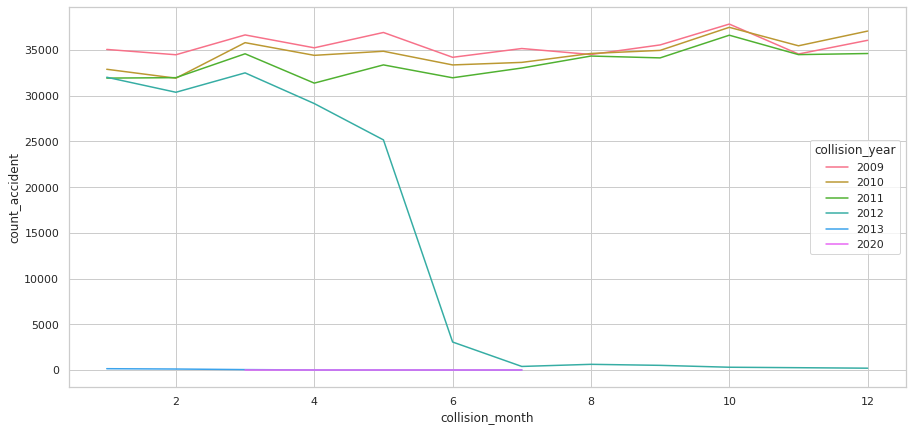

In [15]:
sns.lineplot(
    data=selection_df, 
    x='collision_month', 
    y='count_accident', 
    hue='collision_year', 
    palette=palette
)

***Анализ графика:*** в 2013 и 2020 годах данные отсутствуют, в 2012 - данные не полные: их нельзя учитывать при оценке. В 2009, 2010, 2011 годах чаще всего аварии происходили в октябре - время, когда опавшая на дорогу листва и ограничивающие видимость дожди повышают вероятность ДТП.

***Аналитические задачи:***

*1. Оценить серьезность повреждений транспортного средства в зависимости от трезвости участника*

Порядок решения:
- изучить признаки `collision_damage` - серьезность проишествия и `party_sobrierty` - трезвость участника;
- написать sql-запрос и связать данные двух таблиц (collisions и parties)
- для каждого типа повреждения транспортного средства вывести количество аварий в зависимости от степени трезвости участника (построить сводную таблицу)
- построить график
- сделать выводы
- выдвинуть гипотезы

*2. Как основной фактор аварии связан с состоянием участника (физическое или с учетом принятых лекарств)*

Порядок решения:
- изучить признаки `primary_coll_factor` - основной фактор аварии и `party_grug_physical` - состояние участника;
- написать sql-запрос и связать данные двух таблиц (collisions и parties)
- для каждого основного фактора аварии вывести количество ДТП в зависимости от состояния участника (построить сводную таблицу)
- построить график
- сделать выводы
- выдвинуть гипотезы

3. Исследовать в какое время суток (часы) происходило наибольшее количество ДТП (collisions)
4. Какое количество аварий происходило на каждом типе дороги (шоссе, перекресток, рампа) с любыми значимыми повреждениями автомобиля - все, кроме типа царапина (серьезность проишествия - COLLISION_DAMAGE) (collisions)
5. Какое количество аварий происходило на каждом типе дороги (шоссе, перекресток, рампа) с неподлежащим восстановлению автомобилем (серьезность проишествия - COLLISION_DAMAGE) (collisions)
6. Оценить серьезность проишествия от возраста транспортного средства (в годах) (collisions Vehicles)
7. Какое количество аварий случалось в разную погоду и какая при этом была серьезность проишествий (collisions - count, WEATHER_1, COLLISION_DAMAGE)
8. Оценить взаимосвязь типа ДТП с типом кузова транспортного средства (collisions Vehicles)
9. Как тип аварии связан с трезвостью участника (collisions и parties)
10. Изучить взаимосвязь освещения и типов участников проишествия (collisions и parties)
11. Какая сумма страховки была выплачена по каждому случаю повреждения автомобиля (Parties и collisions)
12. В скольких процентах случаях за весь исследуемый период виновником ДТП является автомобиль (AT_FAULT == 1 таблица Parties)
13. В какой день недели чаще всего случаются ДТП
14. Из-за каких нарушений чаще всего происходят ДТП (PCF_VIOLATION_CATEGORY таблица collisions)

## Создание модели для оценки водительского риска

Проведу первичный отбор факторов, необходимых для обучения моделей. Так как нужно предсказать вероятность ДТП, я буду выбирать факторы которые стали именно причиной аварии, а не последствием.

**Признаки для модели:**
- дата происшествия `COLLISION_DATE` - **беру данные только за 2012 год**; отдельно создам колонку с месяцем проишествия и отдельно с днем недели - число аварий неравномерно распределено по месяцам и дням недели, поэтому эти признаки будут важны в предсказании вероятности ДТП (таблица collisions);
- время происшествия `COLLISION_TIME` - разделю время на восемь интервалов: 07.00-10.00; 10.00-13.00; 13.00-16.00; 16.00-19.00; 19.00-22.00; 22.00-01.00; 01.00-04.00; 04.00-07.00 - в вечерние и утренние часы-пик число аварий может быть больше, чем в остальные временные промежутки (таблица collisions);
- погода `WEATHER_1` - погодные условия могут сильно влиять на вероятность проишествия (таблица collisions);
- серьёзность происшествия `COLLISION_DAMAGE` - **рассматриваю все случаи, кроме царапины** (таблица collisions);
- состояние дороги	`ROAD_SURFACE` - от состояния дороги зависит вероятность аварии (таблица collisions);
- освещение	`LIGHTING` (таблица collisions);
- направление движения	`DIRECTION` - рассмотрю более подробно этот признак уже в собранном по условиям датасете (таблица collisions);
- расстояние от главной дороги (метры) `DISTANCE` (таблица collisions);
- тип дороги `LOCATION_TYPE` (таблица collisions);
- дорожное состояние `ROAD_CONDITION_1` (таблица collisions);
- устройство управления	`CONTROL_CONDITION_1` (таблица collisions);
- тип участника происшествия `PARTY_TYPE` - **взять только car - условие заказчика** (таблица parties);
- **целевой признак** виновность участника	`AT_FAULT` (таблица parties);
- состояние участника: физическое или с учётом принятых лекарств `PARTY_DRUG_PHYSICAL` - этот фактор довольно сложно определить у водителя, посмотрю этот признак более подробно (таблица parties);
- сумма страховки (тыс. долларов) `INSURANCE_PREMIUM` (таблица parties);
- трезвость участника `PARTY_SOBRIETY`- очевидно, что люди в нетрезвом виде не должны садиться за руль, а если такое происходит, то повышается риск аварии (таблица parties);
- наличие телефона в автомобиле (возможности разговаривать по громкой связи) `CELLPHONE_IN_USE` - частая причина аварий - водитель отвлекся на звонок и прочее, поэтому важно иметь в машине держатель для телефона, чтобы разговаривать (на крайний случай) по громкой связи  (таблица parties);
- возраст автомобиля (в годах)	`VEHICLE_AGE` - возраст и состояние автомобиля важны - **учесть этот признак по требованию заказчика** (таблица vehicles);
- тип кузова `VEHICLE_TYPE` - вероятнее, от типа кузова автомобиля зависит риск ДТП (таблица vehicles);
- тип КПП `VEHICLE_TRANSMISSION` - вероятнее, от типа коробки передач зависит риск ДТП (таблица vehicles).

In [16]:
# список колонок из таблицы collisions
columns_collisions = [
    'case_id', 'collision_date', 'collision_time',
    'weather_1', 'collision_damage',
    'road_surface', 'lighting',
    'direction', 'distance',
    'location_type', 'road_condition_1'
]
columns_collisions_sql = ', '.join(columns_collisions)

In [17]:
# список колонок из таблицы parties
columns_parties = [
    'case_id', 'party_type', 
    'at_fault', 'party_drug_physical',
    'party_sobriety', 'party_number', 'insurance_premium'
]
columns_parties_sql = ', '.join(columns_parties)

In [18]:
# список колонок из таблицы vehicles
columns_vehicles = [
    'case_id', 'vehicle_age',
    'vehicle_type', 'vehicle_transmission',
    'party_number'
]
columns_vehicles_sql = ', '.join(columns_vehicles)

In [19]:
# столбцы для sql-запроса
excluded_columns = {'case_id', 'party_number', 'party_type'}
result_columns = (set(columns_collisions) | set(columns_parties) | set(columns_vehicles)) - excluded_columns
result_columns_sql = ', '.join(result_columns)
result_columns

{'at_fault',
 'collision_damage',
 'collision_date',
 'collision_time',
 'direction',
 'distance',
 'insurance_premium',
 'lighting',
 'location_type',
 'party_drug_physical',
 'party_sobriety',
 'road_condition_1',
 'road_surface',
 'vehicle_age',
 'vehicle_transmission',
 'vehicle_type',
 'weather_1'}

In [20]:
query = f'''
WITH c AS
    (SELECT 
        {columns_collisions_sql}
    FROM collisions
    WHERE 
        collision_damage <> 'scratch' AND
        DATE(DATE_TRUNC('YEAR', collision_date)) BETWEEN '2012-01-01' AND '2012-12-31'),

p AS (SELECT 
    {columns_parties_sql}
FROM parties
WHERE 
    party_type = 'car'),

v AS (SELECT {columns_vehicles_sql}
FROM vehicles)
    
SELECT {result_columns_sql}
FROM c
INNER JOIN p ON p.case_id = c.case_id
INNER JOIN v ON v.case_id = p.case_id AND v.party_number = p.party_number
'''

accident = pd.read_sql_query(query, con=engine)

In [21]:
get_info(accident)

(56248, 17)

,vehicle_transmission,lighting,direction,distance,insurance_premium,vehicle_age,party_drug_physical,vehicle_type,collision_date,party_sobriety,location_type,at_fault,weather_1,road_surface,road_condition_1,collision_time,collision_damage
0,auto,daylight,None,0.0,42.0,2.0,None,sedan,2012-03-30,had not been drinking,None,0,cloudy,dry,other,07:40:00,small damage
1,auto,daylight,None,0.0,31.0,5.0,None,sedan,2012-04-02,had not been drinking,None,0,clear,dry,normal,12:54:00,small damage
2,auto,daylight,None,0.0,21.0,1.0,None,sedan,2012-11-13,had not been drinking,None,0,clear,dry,normal,16:35:00,small damage
3,auto,dark with street lights,east,5.0,31.0,4.0,None,sedan,2012-09-05,had not been drinking,None,0,clear,dry,normal,19:32:00,small damage
4,auto,daylight,None,0.0,41.0,6.0,None,coupe,2012-11-03,had not been drinking,None,0,clear,dry,normal,13:15:00,middle damage


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_transmission  55389 non-null  object 
 1   lighting              56094 non-null  object 
 2   direction             43230 non-null  object 
 3   distance              56248 non-null  float64
 4   insurance_premium     55701 non-null  float64
 5   vehicle_age           54554 non-null  float64
 6   party_drug_physical   2857 non-null   object 
 7   vehicle_type          56248 non-null  object 
 8   collision_date        56248 non-null  object 
 9   party_sobriety        55376 non-null  object 
 10  location_type         25932 non-null  object 
 11  at_fault              56248 non-null  int64  
 12  weather_1             56080 non-null  object 
 13  road_surface          55900 non-null  object 
 14  road_condition_1      55999 non-null  object 
 15  collision_time     

None

,distance,insurance_premium,vehicle_age,at_fault
count,5.624800e+04,55701.000000,54554.000000,56248.000000
mean,8.594387e+02,37.607170,4.856472,0.504427
std,7.240295e+03,16.328721,3.234503,0.499985
min,0.000000e+00,0.000000,0.000000,0.000000
25%,7.000000e+00,24.000000,3.000000,0.000000
50%,1.350000e+02,34.000000,4.000000,1.000000
75%,5.450000e+02,49.000000,7.000000,1.000000
max,1.584000e+06,105.000000,161.000000,1.000000


**Вывод:** в выборке `accident` содержится 56248 строк и 17 столбцов. Есть пропуски, аномалии и различные типы данных, которые нужно дополнительно преобразовать. 

## Предобработка датасета

### Проверка на дубликаты

In [22]:
# явные дубликаты
accident.duplicated().sum()

20

In [23]:
# удаление явных дубликатов
accident = accident.drop_duplicates().reset_index(drop=True)

In [24]:
# проверка на неявные дубликаты для категориальных столбцов
cat_columns = [
    'party_sobriety', 'collision_damage',
    'party_drug_physical',
    'vehicle_type', 'road_surface',
    'direction', 'lighting',
    'vehicle_transmission', 'location_type',
    'road_condition_1', 'weather_1'
]

for col in cat_columns:
    print(accident[col].unique(), end='\n\n')

['had not been drinking' 'impairment unknown'
 'had been drinking, under influence'
 'had been drinking, impairment unknown' None
 'had been drinking, not under influence' 'not applicable']

['small damage' 'middle damage' 'fatal' 'severe damage']

[None 'G' 'sleepy/fatigued' 'under drug influence' 'impairment - physical'
 'not applicable']

['sedan' 'coupe' 'other']

['dry' 'wet' 'snowy' None 'slippery']

[None 'east' 'west' 'north' 'south']

['daylight' 'dark with street lights' 'dusk or dawn'
 'dark with no street lights' None
 'dark with street lights not functioning']

['auto' 'manual' None]

[None 'highway' 'ramp' 'intersection']

['other' 'normal' 'loose material' 'construction' None 'reduced width'
 'obstruction' 'holes' 'flooded']

['cloudy' 'clear' 'fog' 'other' 'raining' None 'wind' 'snowing']



Неявных дубликатов не обнаружено, но в названиях категорий обнаружены различные символы, заменю их и пробелы на нижнее подчеркивание.

In [25]:
pattern = re.compile(r'[ ,-/]+')
for col in cat_columns:
    accident[col] = accident[col].str.replace(pattern, '_')
    print(accident[col].unique(), end='\n\n')

['had_not_been_drinking' 'impairment_unknown'
 'had_been_drinking_under_influence'
 'had_been_drinking_impairment_unknown' None
 'had_been_drinking_not_under_influence' 'not_applicable']

['small_damage' 'middle_damage' 'fatal' 'severe_damage']

[None 'G' 'sleepy_fatigued' 'under_drug_influence' 'impairment_physical'
 'not_applicable']

['sedan' 'coupe' 'other']

['dry' 'wet' 'snowy' None 'slippery']

[None 'east' 'west' 'north' 'south']

['daylight' 'dark_with_street_lights' 'dusk_or_dawn'
 'dark_with_no_street_lights' None
 'dark_with_street_lights_not_functioning']

['auto' 'manual' None]

[None 'highway' 'ramp' 'intersection']

['other' 'normal' 'loose_material' 'construction' None 'reduced_width'
 'obstruction' 'holes' 'flooded']

['cloudy' 'clear' 'fog' 'other' 'raining' None 'wind' 'snowing']



### Обработка пропущенных значений

Более подробно исследую признаки, посмотрю на количество пропусков в столбцах и приму решение об окончательном наборе признаков для обучения модели.

In [26]:
# количество пропусков
accident.isna().sum()

vehicle_transmission      859
lighting                  154
direction               13016
distance                    0
insurance_premium         547
vehicle_age              1693
party_drug_physical     53371
vehicle_type                0
collision_date              0
party_sobriety            872
location_type           30307
at_fault                    0
weather_1                 168
road_surface              348
road_condition_1          249
collision_time             88
collision_damage            0
dtype: int64

В столбцах с типом дороги `location_type` и направлением движения `direction` есть достаточно большое количество пропусков, но на мой взгляд, эти факторы важны для определения риска ДТП по выбранному маршруту, и чтобы не удалять эти колонки из исследования, я заполню пропущенные значения в них как `other`.

In [27]:
accident['location_type'] = accident['location_type'].fillna('other')
accident['direction'] = accident['direction'].fillna('other')

Столбец `party_drug_physical` с состоянием участника имеет 95% пропусков - смысл этого столбца теряется для обучения модели. Удалю этот признак из датасета.

In [28]:
accident = accident.drop(['party_drug_physical'], axis=1)

С оставшимися пропусками далее:

In [29]:
# столбец vehicle_age
accident['vehicle_age'].unique()

array([  2.,   5.,   1.,   4.,   6.,   7.,   3.,  10.,   9.,  11.,   8.,
        13.,   0.,  14.,  nan,  12.,  15.,  16.,  17.,  19., 161.])

In [30]:
accident.query('vehicle_age == 161')['vehicle_age'].count()

2

161 год в колонке с возрастом автомобиля - выброс. Удалю такие строки:

In [31]:
accident = accident.query('vehicle_age != 161')

In [32]:
# заполню пропуски интерполированным значением между верхним и нижним значением от пропуска
accident['vehicle_age'] = accident['vehicle_age'].interpolate(method='linear').astype('int')

In [33]:
# столбец insurance_premium
accident['insurance_premium'] = accident['insurance_premium'].interpolate(method='linear').astype('int')

In [34]:
# столбец vehicle_transmission
accident['vehicle_transmission'] = accident['vehicle_transmission'].fillna('other')

In [35]:
# столбец party_sobriety
accident['party_sobriety'].unique()

array(['had_not_been_drinking', 'impairment_unknown',
       'had_been_drinking_under_influence',
       'had_been_drinking_impairment_unknown', None,
       'had_been_drinking_not_under_influence', 'not_applicable'],
      dtype=object)

In [36]:
# процент пропущенных значений
round((accident['party_sobriety'].isna().sum()) * 100 / len(accident), 3)

1.551

Заменю пропущенные значения категорией `not applicable` - что значит  "не оценивался". Я считаю, что это равносильно пропускам и 1.5% значений можно заменить таким образом.

In [37]:
accident['party_sobriety'] = accident['party_sobriety'].fillna('not applicable')

Осталось 5 столбцов с небольшим значением пропусков, посмотрю какой процент от общих записей они составляют в датасете:

In [38]:
# столбец collision_time
# процент пропущенных значений
round((accident['collision_time'].isna().sum()) * 100 / len(accident), 3)

0.157

In [39]:
# столбец weather_1
# процент пропущенных значений
round((accident['weather_1'].isna().sum()) * 100 / len(accident), 3)

0.299

In [40]:
# столбец road_condition_1
# процент пропущенных значений
round((accident['road_condition_1'].isna().sum()) * 100 / len(accident), 3)

0.443

In [41]:
# столбец road_surface
# процент пропущенных значений
round((accident['road_surface'].isna().sum()) * 100 / len(accident), 3)

0.619

In [42]:
# столбец lighting
# процент пропущенных значений
round((accident['lighting'].isna().sum()) * 100 / len(accident), 3)

0.274

Во всех столбцах процент пропусков меньше 1%. Удалю такие строки:

In [43]:
accident = accident.dropna()

In [44]:
accident.isna().sum()

vehicle_transmission    0
lighting                0
direction               0
distance                0
insurance_premium       0
vehicle_age             0
vehicle_type            0
collision_date          0
party_sobriety          0
location_type           0
at_fault                0
weather_1               0
road_surface            0
road_condition_1        0
collision_time          0
collision_damage        0
dtype: int64

### Преобразование типов данных

In [45]:
accident['collision_date'] = accident['collision_date'].astype('datetime64')

In [46]:
accident['vehicle_age'] = accident['vehicle_age'].astype('int')

In [47]:
accident['distance'] = accident['distance'].astype('int')

In [48]:
accident['insurance_premium'] = accident['insurance_premium'].astype('int')

### Добавление новых столбцов

Создам три столбца с временным интервалом, месяцем и днем недели ДТП. И после удалю исходные столбцы `collision_time` и `collision_date`.

In [49]:
def determine_time_interval(value):
    if datetime.time(hour=7) <= value < datetime.time(hour=10):
        name = '07.00-10.00'
    if datetime.time(hour=10) <= value < datetime.time(hour=13):
        name = '10.00-13.00'
    if datetime.time(hour=13) <= value < datetime.time(hour=16):
        name = '13.00-16.00'
    if datetime.time(hour=16) <= value < datetime.time(hour=19):
        name = '16.00-19.00'
    if datetime.time(hour=19) <= value < datetime.time(hour=22):
        name = '19.00-22.00'
    if datetime.time(hour=22) <= value or value < datetime.time(hour=1):
        name = '22.00-01.00'
    if datetime.time(hour=1) <= value < datetime.time(hour=4):
        name = '01.00-04.00'
    if datetime.time(hour=4) <= value < datetime.time(hour=7):
        name = '04.00-07.00'
    return name

In [50]:
accident['time_interval'] = accident['collision_time'].apply(determine_time_interval)

In [51]:
accident['day_of_week'] = accident['collision_date'].dt.day_name().str.lower()
accident['month'] = accident['collision_date'].dt.month_name().str.lower()

In [52]:
accident = accident.drop(['collision_time', 'collision_date'], axis=1)

In [53]:
accident.head()

,vehicle_transmission,lighting,direction,distance,insurance_premium,vehicle_age,vehicle_type,party_sobriety,location_type,at_fault,weather_1,road_surface,road_condition_1,collision_damage,time_interval,day_of_week,month
0,auto,daylight,other,0,42,2,sedan,had_not_been_drinking,other,0,cloudy,dry,other,small_damage,07.00-10.00,friday,march
1,auto,daylight,other,0,31,5,sedan,had_not_been_drinking,other,0,clear,dry,normal,small_damage,10.00-13.00,monday,april
2,auto,daylight,other,0,21,1,sedan,had_not_been_drinking,other,0,clear,dry,normal,small_damage,16.00-19.00,tuesday,november
3,auto,dark_with_street_lights,east,5,31,4,sedan,had_not_been_drinking,other,0,clear,dry,normal,small_damage,19.00-22.00,wednesday,september
4,auto,daylight,other,0,41,6,coupe,had_not_been_drinking,other,0,clear,dry,normal,middle_damage,13.00-16.00,saturday,november


**Итоговые признаки для модели:**

In [54]:
accident.columns

Index(['vehicle_transmission', 'lighting', 'direction', 'distance',
       'insurance_premium', 'vehicle_age', 'vehicle_type', 'party_sobriety',
       'location_type', 'at_fault', 'weather_1', 'road_surface',
       'road_condition_1', 'collision_damage', 'time_interval', 'day_of_week',
       'month'],
      dtype='object')

## Исследовательский анализ данных

In [55]:
plt.rcParams['figure.figsize'] = [9, 9]
sns.set_theme(style="whitegrid")

In [56]:
sns.set_theme(style='ticks')

- **исследование признака возраста автомобиля `vehicle_age`**

In [57]:
accident['vehicle_age'].describe()

count    55411.000000
mean         4.838408
std          3.072284
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         19.000000
Name: vehicle_age, dtype: float64

Text(0.5, 1.0, 'Histogram of vehicle age')

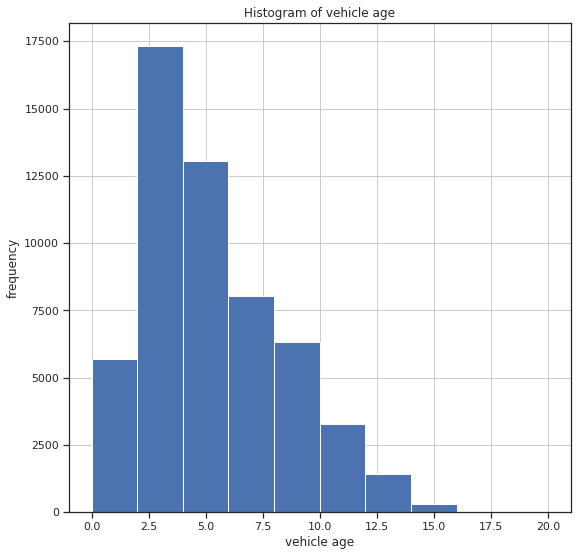

In [58]:
accident['vehicle_age'].hist(range=(0, 20))
plt.xlabel('vehicle age')
plt.ylabel('frequency')
plt.title('Histogram of vehicle age')

<AxesSubplot:xlabel='vehicle_age'>

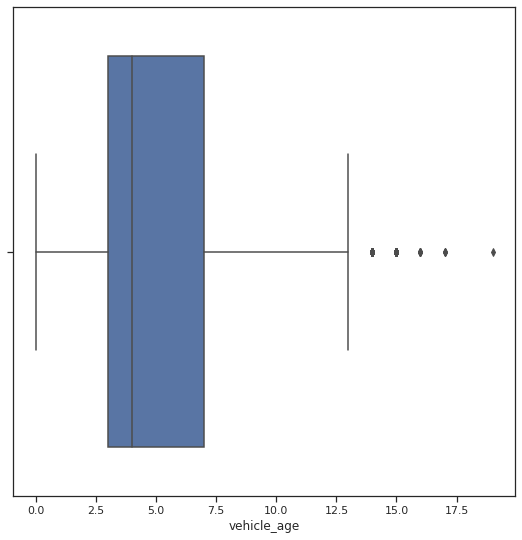

In [59]:
sns.boxplot(accident['vehicle_age'])

**Анализ графиков:** гистограмма значений распределена нормально, но справа есть хвост - значит есть аномальные значения, что и подтверждает график boxplot. Посмотрю, сколько строк в датасете с возрастом автомобиля больше 13 лет:

In [60]:
abnormal_value = accident.query('vehicle_age > 13')['vehicle_age'].count()
abnormal_value

323

In [61]:
# процент аномальных значений
round(abnormal_value * 100 / len(accident), 3)

0.583

Таких данных всего ~ 0.5% - избавлюся от таких строк в датасете:

In [62]:
accident = accident.query('vehicle_age <= 13')

- **исследование признака расстояние от главной дороги `distance`**

In [63]:
# перевод значений из метров в километры
accident['distance'] = round(accident['distance'] / 1000, 3)

In [64]:
accident['distance'].describe()

count    55088.000000
mean         0.863245
std          7.306479
min          0.000000
25%          0.008000
50%          0.137000
75%          0.550000
max       1584.000000
Name: distance, dtype: float64

In [65]:
# удаляю одно явно выбивающееся значение
accident = accident.query('distance != 1584')

Text(0.5, 1.0, 'Histogram of distance')

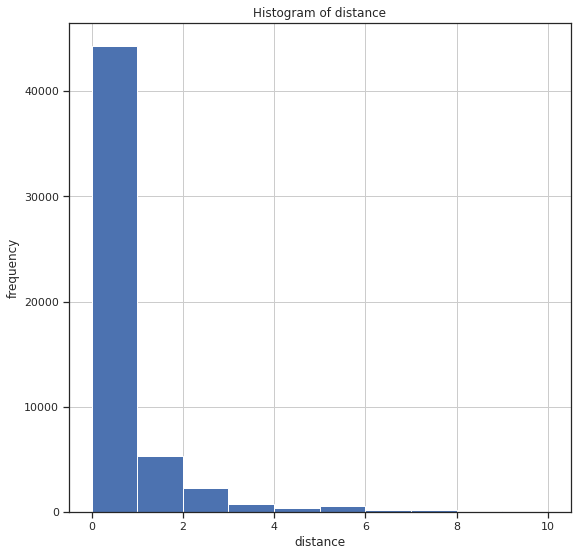

In [66]:
accident['distance'].hist(range=(0, 10))
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('Histogram of distance')

<AxesSubplot:xlabel='distance'>

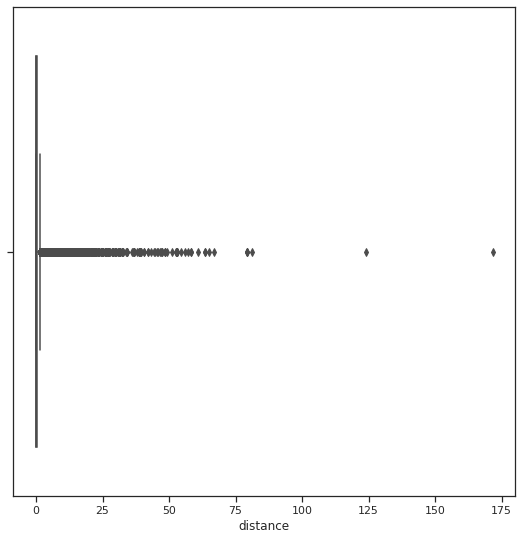

In [67]:
sns.boxplot(accident['distance'])

**Анализ графиков:** присутствует большое количество аномалий. Но так как данные не имеют нормального распределения, то не буду избавляться от аномальных значений.

- **исследование признака сумма страховки `insurance_premium`**

In [68]:
accident['insurance_premium'].describe()

count    55087.000000
mean        37.380834
std         16.018692
min          0.000000
25%         24.000000
50%         34.000000
75%         48.000000
max        105.000000
Name: insurance_premium, dtype: float64

Text(0.5, 1.0, 'Histogram of insurance premium')

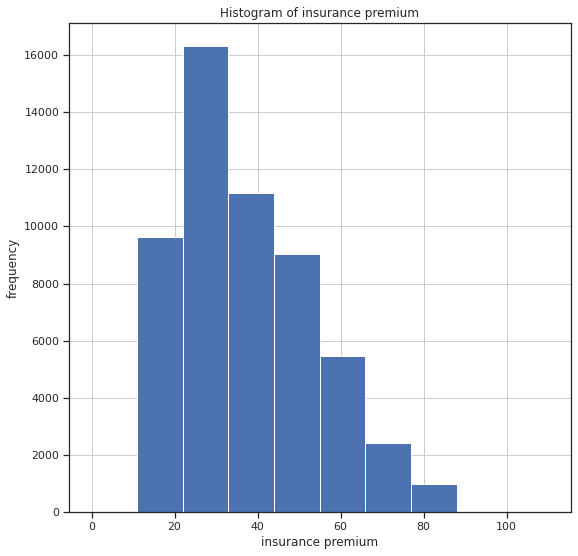

In [69]:
accident['insurance_premium'].hist(range=(0, 110))
plt.xlabel('insurance premium')
plt.ylabel('frequency')
plt.title('Histogram of insurance premium')

<AxesSubplot:xlabel='insurance_premium'>

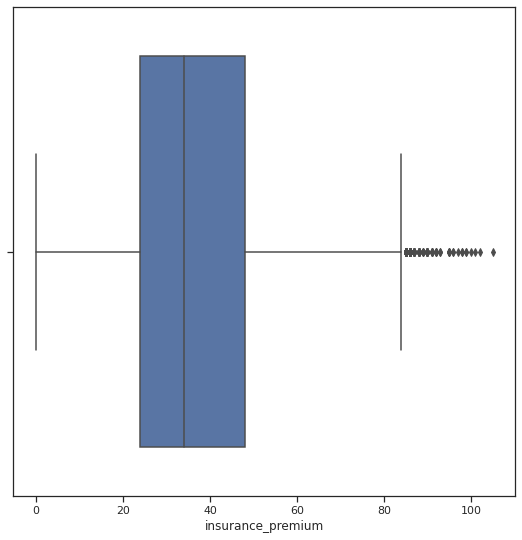

In [70]:
sns.boxplot(accident['insurance_premium'])

- **гистограмма с частотой распределения аварий по дням недели `day_of_week`:**

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

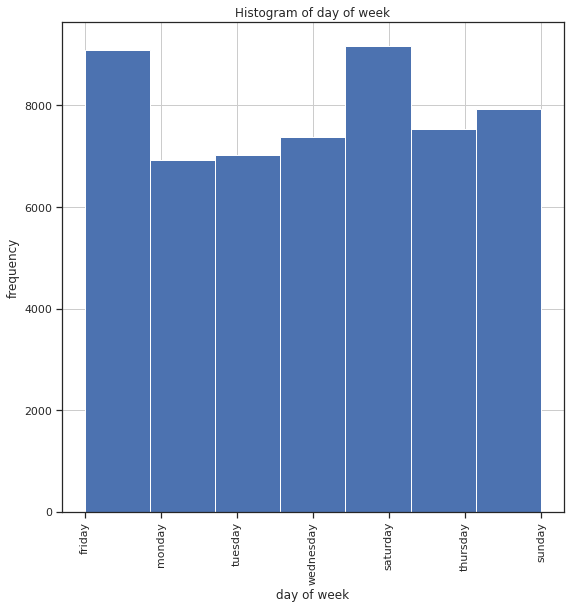

In [71]:
accident['day_of_week'].hist(bins=7)
plt.xlabel('day of week')
plt.ylabel('frequency')
plt.title('Histogram of day of week')
plt.xticks(rotation=90)

***Анализ графика:*** аварии чаще всего происходят по пятницам и субботам - дни, в которые люди после рабочей недели выезжают за город и на дорогах случаются пробки из-за скопления машин.

- **гистограмма с частотой распределения аварий по времени `time_interval`:**

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

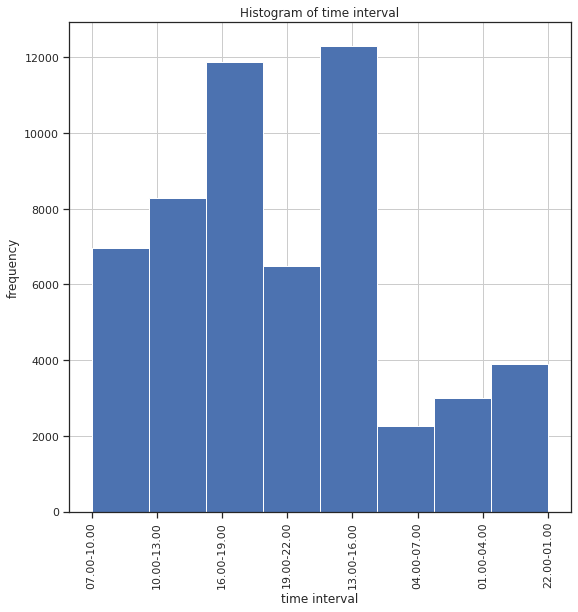

In [72]:
accident['time_interval'].hist(bins=8)
plt.xlabel('time interval')
plt.ylabel('frequency')
plt.title('Histogram of time interval')
plt.xticks(rotation=90)

***Анализ графика:*** число ДТП больше в вечерний час-пик и в обеденное время. В утренний час-пик число аварий почти в два раза меньше, в сравнении с вечерним.

### Разделение данных на выборки

In [73]:
features = accident.drop(['at_fault'], axis=1)
target = accident['at_fault']

In [74]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, shuffle=True, random_state=SEED
)

In [75]:
# размеры полученных выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(38560, 16)
(38560,)
(16527, 16)
(16527,)


### Масштабирование количественных признаков

In [76]:
numeric_columns = ['vehicle_age', 'distance', 'insurance_premium']

In [77]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [78]:
display(features_train.head())
display(features_test.head())

,vehicle_transmission,lighting,direction,distance,insurance_premium,vehicle_age,vehicle_type,party_sobriety,location_type,weather_1,road_surface,road_condition_1,collision_damage,time_interval,day_of_week,month
37669,manual,dark_with_no_street_lights,east,0.005051,0.180952,0.230769,coupe,had_been_drinking_under_influence,highway,cloudy,dry,normal,severe_damage,22.00-01.00,friday,april
6083,auto,daylight,other,0.000000,0.790476,1.000000,coupe,had_not_been_drinking,other,cloudy,dry,normal,middle_damage,13.00-16.00,sunday,january
20130,auto,dark_with_no_street_lights,west,0.006098,0.342857,0.384615,sedan,had_not_been_drinking,highway,clear,dry,normal,small_damage,16.00-19.00,thursday,february
42868,manual,daylight,north,0.005316,0.209524,0.230769,coupe,had_not_been_drinking,highway,clear,dry,normal,middle_damage,13.00-16.00,wednesday,may
38156,auto,daylight,west,0.001957,0.580952,0.769231,sedan,had_not_been_drinking,other,clear,dry,normal,small_damage,10.00-13.00,saturday,april


,vehicle_transmission,lighting,direction,distance,insurance_premium,vehicle_age,vehicle_type,party_sobriety,location_type,weather_1,road_surface,road_condition_1,collision_damage,time_interval,day_of_week,month
13581,manual,daylight,other,0.000000,0.276190,0.307692,coupe,had_not_been_drinking,other,clear,dry,normal,middle_damage,07.00-10.00,saturday,february
39757,manual,daylight,north,0.001010,0.666667,0.538462,sedan,had_not_been_drinking,other,clear,dry,normal,small_damage,13.00-16.00,thursday,april
39342,manual,dark_with_no_street_lights,east,0.005051,0.200000,0.230769,coupe,had_been_drinking_under_influence,other,cloudy,wet,normal,middle_damage,01.00-04.00,friday,may
23974,manual,daylight,other,0.000000,0.352381,0.153846,sedan,had_not_been_drinking,other,clear,dry,normal,small_damage,10.00-13.00,thursday,april
10223,manual,daylight,north,0.000631,0.523810,0.615385,sedan,had_not_been_drinking,highway,clear,dry,normal,small_damage,10.00-13.00,sunday,february


### Кодирование категориальных признаков

In [79]:
cat_columns = [
    'party_sobriety', 'collision_damage',
    'vehicle_type', 'road_surface',
    'direction', 'lighting',
    'vehicle_transmission', 'location_type',
    'road_condition_1', 'weather_1',
    'time_interval', 'day_of_week', 'month'
]

In [80]:
for cat in cat_columns:
    features_train[cat] = features_train[cat].astype('category')
    features_test[cat] = features_test[cat].astype('category')

- обучающая выборка:

In [81]:
features_train_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train_encoder[cat_columns])
features_train_encoded = encoder.transform(features_train_encoder[cat_columns]).toarray()
features_train_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [82]:
features_train_df = pd.DataFrame(
    features_train_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_train.index
)
features_train_df.head()

,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
37669,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6083,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20130,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42868,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38156,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
features_train_drop = features_train.drop(cat_columns, axis=1)
features_train_drop.head()

,distance,insurance_premium,vehicle_age
37669,0.005051,0.180952,0.230769
6083,0.000000,0.790476,1.000000
20130,0.006098,0.342857,0.384615
42868,0.005316,0.209524,0.230769
38156,0.001957,0.580952,0.769231


In [84]:
features_train_ohe = pd.concat((features_train_drop, features_train_df), axis=1)
features_train_ohe.head()

,distance,insurance_premium,vehicle_age,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
37669,0.005051,0.180952,0.230769,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6083,0.000000,0.790476,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20130,0.006098,0.342857,0.384615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42868,0.005316,0.209524,0.230769,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38156,0.001957,0.580952,0.769231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- тестовая выборка:

In [85]:
features_test_encoder = features_test.loc[:]
features_test_encoded = encoder.transform(features_test_encoder[cat_columns]).toarray()

In [86]:
features_test_df = pd.DataFrame(
    features_test_encoded, 
    columns=encoder.get_feature_names(cat_columns),
    index=features_test.index
)
features_test_df.head()

,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
13581,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39757,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39342,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23974,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10223,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
features_test_drop = features_test.drop(cat_columns, axis=1)
features_test_drop.head()

,distance,insurance_premium,vehicle_age
13581,0.000000,0.276190,0.307692
39757,0.001010,0.666667,0.538462
39342,0.005051,0.200000,0.230769
23974,0.000000,0.352381,0.153846
10223,0.000631,0.523810,0.615385


In [88]:
features_test_ohe = pd.concat((features_test_drop, features_test_df), axis=1)
features_test_ohe.head()

,distance,insurance_premium,vehicle_age,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
13581,0.000000,0.276190,0.307692,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39757,0.001010,0.666667,0.538462,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39342,0.005051,0.200000,0.230769,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23974,0.000000,0.352381,0.153846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10223,0.000631,0.523810,0.615385,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,distance,insurance_premium,vehicle_age,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
37669,0.005051,0.180952,0.230769,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6083,0.000000,0.790476,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20130,0.006098,0.342857,0.384615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42868,0.005316,0.209524,0.230769,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38156,0.001957,0.580952,0.769231,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,distance,insurance_premium,vehicle_age,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not applicable,party_sobriety_not_applicable,collision_damage_middle_damage,collision_damage_severe_damage,collision_damage_small_damage,vehicle_type_other,vehicle_type_sedan,road_surface_slippery,road_surface_snowy,road_surface_wet,direction_north,direction_other,direction_south,direction_west,lighting_dark_with_street_lights,lighting_dark_with_street_lights_not_functioning,lighting_daylight,lighting_dusk_or_dawn,vehicle_transmission_manual,vehicle_transmission_other,location_type_intersection,location_type_other,location_type_ramp,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose_material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced_width,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,time_interval_04.00-07.00,time_interval_07.00-10.00,time_interval_10.00-13.00,time_interval_13.00-16.00,time_interval_16.00-19.00,time_interval_19.00-22.00,time_interval_22.00-01.00,day_of_week_monday,day_of_week_saturday,day_of_week_sunday,day_of_week_thursday,day_of_week_tuesday,day_of_week_wednesday,month_august,month_december,month_february,month_january,month_july,month_june,month_march,month_may,month_november,month_october,month_september
13581,0.000000,0.276190,0.307692,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39757,0.001010,0.666667,0.538462,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39342,0.005051,0.200000,0.230769,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23974,0.000000,0.352381,0.153846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10223,0.000631,0.523810,0.615385,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
features_train_ohe.shape

(38560, 67)

In [91]:
features_test_ohe.shape

(16527, 67)

### Метод отбора признаков с помощью критерия Фишера

In [92]:
ranks = fisher_score.fisher_score(features_train_ohe[:1000].to_numpy(), target_train[:1000].to_numpy())

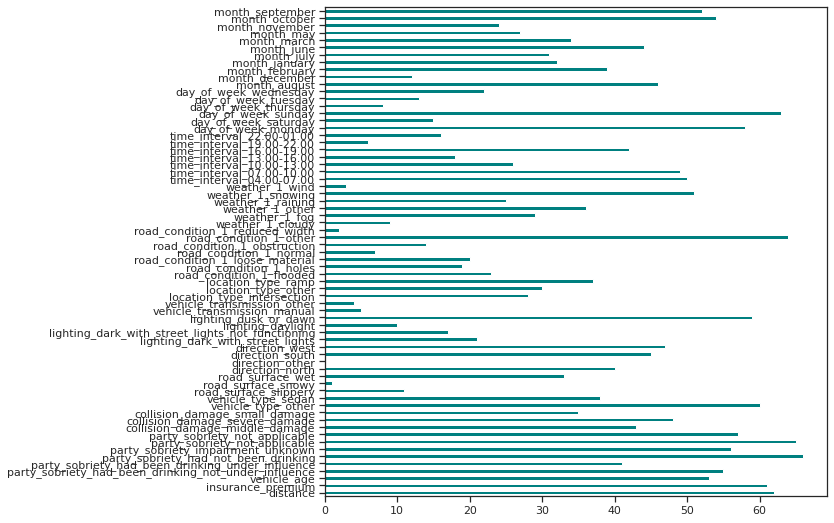

In [93]:
feature_importances = pd.Series(ranks, features_train_ohe.columns)
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [94]:
filtered_features = []

for rank, name in zip(ranks, features_train_ohe.columns):
    if rank >= 20:
        filtered_features.append(name)
        
filtered_features

['distance',
 'insurance_premium',
 'vehicle_age',
 'party_sobriety_had_been_drinking_not_under_influence',
 'party_sobriety_had_been_drinking_under_influence',
 'party_sobriety_had_not_been_drinking',
 'party_sobriety_impairment_unknown',
 'party_sobriety_not applicable',
 'party_sobriety_not_applicable',
 'collision_damage_middle_damage',
 'collision_damage_severe_damage',
 'collision_damage_small_damage',
 'vehicle_type_other',
 'vehicle_type_sedan',
 'road_surface_wet',
 'direction_north',
 'direction_south',
 'direction_west',
 'lighting_dark_with_street_lights',
 'lighting_dusk_or_dawn',
 'location_type_intersection',
 'location_type_other',
 'location_type_ramp',
 'road_condition_1_flooded',
 'road_condition_1_loose_material',
 'road_condition_1_other',
 'weather_1_fog',
 'weather_1_other',
 'weather_1_raining',
 'weather_1_snowing',
 'time_interval_04.00-07.00',
 'time_interval_07.00-10.00',
 'time_interval_10.00-13.00',
 'time_interval_16.00-19.00',
 'day_of_week_monday',
 'da

In [95]:
features_train_ohe = features_train_ohe[filtered_features]
features_test_ohe = features_test_ohe[filtered_features]

In [96]:
features_train_ohe.shape

(38560, 47)

### Подбор гиперпараметров

Буду обучать следующие модели, предварительно подобрав наилучшие гиперпараметры с помощью `optuna`:
- CatBoostClassifier;
- GradientBoostingClassifier;
- RandomForestClassifier;
- LGBMClassifier;
- LogisticRegression;
- SVC.

- **CatBoostClassifier**

In [97]:
# def objective(trail):
    
#     param = {
#         "objective": trail.suggest_categorical("objective", ['Logloss', 'CrossEntropy']),
#         "iterations": trail.suggest_int('iterations', 50, 800, log=True),
#         "depth": trail.suggest_int('depth', 3, 5),
#         "early_stopping_rounds": trail.suggest_int('early_stopping_rounds', 10, 40, log=True),
#         "learning_rate": trail.suggest_float('learning_rate', 0.001, 0.01, log=True)
#     }
    
#     cbc = CatBoostClassifier(**param, cat_features=cat_columns, random_seed=SEED)
#     cbc.fit(features_train, target_train, eval_set=[(features_test, target_test)], verbose=0)
#     roc_auc = roc_auc_score(target_test, cbc.predict(features_test))
#     return roc_auc

In [98]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [99]:
# study.best_trial

**FrozenTrial(number=94, values=[0.6642386516023959], datetime_start=datetime.datetime(2022, 10, 5, 12, 46, 17, 981572), datetime_complete=datetime.datetime(2022, 10, 5, 12, 47, 27, 845238), params={'objective': 'CrossEntropy', 'iterations': 800, 'depth': 5, 'early_stopping_rounds': 21, 'learning_rate': 0.009201593215030416}, distributions={'objective': CategoricalDistribution(choices=('Logloss', 'CrossEntropy')), 'iterations': IntDistribution(high=800, log=True, low=50, step=1), 'depth': IntDistribution(high=5, log=False, low=3, step=1), 'early_stopping_rounds': IntDistribution(high=40, log=True, low=10, step=1), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=94, state=TrialState.COMPLETE, value=None)**

- **GradientBoostingClassifier**

In [100]:
# def objective(trail):
    
#     param = {
#         "n_estimators": trail.suggest_int('n_estimators', 100, 800, log=True),
#         "max_depth": trail.suggest_int('max_depth', 3, 6),
#         "learning_rate": trail.suggest_float('learning_rate', 0.001, 0.1, log=True),
#         "min_samples_split": trail.suggest_int('min_samples_split', 2, 4)
#     }
    
#     gbc = GradientBoostingClassifier(**param, random_state=SEED)
#     gbc.fit(features_train_ohe, target_train)
#     roc_auc = roc_auc_score(target_test, gbc.predict(features_test_ohe))
#     return roc_auc

In [101]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [102]:
# study.best_trial

**FrozenTrial(number=93, values=[0.6667888201550254], datetime_start=datetime.datetime(2022, 10, 4, 10, 54, 3, 231983), datetime_complete=datetime.datetime(2022, 10, 4, 10, 54, 18, 371509), params={'n_estimators': 323, 'max_depth': 3, 'learning_rate': 0.06134170833638914, 'min_samples_split': 3}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=100, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=93, state=TrialState.COMPLETE, value=None)**

- **RandomForestClassifier**

In [103]:
# def objective(trail):
    
#     param = {
#         "n_estimators": trail.suggest_int('n_estimators', 100, 800, log=True),
#         "max_depth": trail.suggest_int('max_depth', 3, 7),
#         "min_samples_split": trail.suggest_int('min_samples_split', 2, 4)
#     }
    
#     rfc = RandomForestClassifier(**param, class_weight='balanced', random_state=SEED)
#     rfc.fit(features_train_ohe, target_train)
#     roc_auc = roc_auc_score(target_test, rfc.predict(features_test_ohe))
#     return roc_auc

In [104]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [105]:
# study.best_trial

**FrozenTrial(number=74, values=[0.6563222356643862], datetime_start=datetime.datetime(2022, 10, 4, 11, 10, 15, 991770), datetime_complete=datetime.datetime(2022, 10, 4, 11, 10, 21, 312669), params={'n_estimators': 335, 'max_depth': 7, 'min_samples_split': 3}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=100, step=1), 'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=4, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=74, state=TrialState.COMPLETE, value=None)**

- **LGBMClassifier**

In [106]:
# def objective(trail):
    
#     param = {
#         "n_estimators": trail.suggest_int('n_estimators', 100, 800, log=True),
#         "max_depth": trail.suggest_int('max_depth', 3, 6),
#         "learning_rate": trail.suggest_float('learning_rate', 0.001, 0.01, log=True)
#     }
    
#     lgbm = lgb.LGBMClassifier(**param, class_weight='balanced', random_state=SEED)
#     lgbm.fit(features_train, target_train, verbose=0)
#     roc_auc = roc_auc_score(target_test, lgbm.predict(features_test))
#     return roc_auc

In [107]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [108]:
# study.best_trial

**FrozenTrial(number=28, values=[0.6660829186089747], datetime_start=datetime.datetime(2022, 10, 5, 13, 15, 35, 713319), datetime_complete=datetime.datetime(2022, 10, 5, 13, 15, 56, 603713), params={'n_estimators': 683, 'max_depth': 6, 'learning_rate': 0.00978625480717987}, distributions={'n_estimators': IntDistribution(high=800, log=True, low=100, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=28, state=TrialState.COMPLETE, value=None)**

- **LogicticRegression**

In [109]:
# def objective(trial):
    
#     param = {
#         'solver': trial.suggest_categorical('solver', ['saga', 'lbfgs']),
#         'penalty': trial.suggest_categorical('penalty', ['l2', 'none']),
#         'C': trial.suggest_float('C', 1.0, 10.0, log=True),
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'tol': trial.suggest_float('tol', 0.0001, 0.01, log=True)
#     }
    
#     lr = LogisticRegression(**param, class_weight='balanced', random_state=SEED, n_jobs=-1)
#     lr.fit(features_train_ohe, target_train)
#     roc_auc = roc_auc_score(target_test, lr.predict(features_test_ohe))
#     return roc_auc

In [110]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [111]:
# study.best_trial

**FrozenTrial(number=94, values=[0.6385497122252536], datetime_start=datetime.datetime(2022, 10, 4, 11, 25, 12, 209084), datetime_complete=datetime.datetime(2022, 10, 4, 11, 25, 12, 733623), params={'solver': 'saga', 'penalty': 'l2', 'C': 2.5396551603320248, 'fit_intercept': True, 'tol': 0.006969457810027698}, distributions={'solver': CategoricalDistribution(choices=('saga', 'lbfgs')), 'penalty': CategoricalDistribution(choices=('l2', 'none')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=94, state=TrialState.COMPLETE, value=None)**

- **Support Vector Classification**

In [112]:
# def objective(trial):
    
#     param = {
#         'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
#         'C': trial.suggest_float('C', 1.0, 10.0, log=True),
#         'tol': trial.suggest_float('tol', 0.0001, 0.01, log=True)
#     }
    
#     svc = SVC(**param, class_weight='balanced', random_state=SEED)
#     svc.fit(features_train_ohe, target_train)
#     roc_auc = roc_auc_score(target_test, svc.predict(features_test_ohe))
#     return roc_auc

In [113]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

In [114]:
# study.best_trial

**FrozenTrial(number=32, values=[0.6350071268202022], datetime_start=datetime.datetime(2022, 10, 12, 8, 6, 48, 351185), datetime_complete=datetime.datetime(2022, 10, 12, 8, 10, 14, 286176), params={'kernel': 'poly', 'C': 1.1432821887270568, 'tol': 0.009987172430596679}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=32, state=TrialState.COMPLETE, value=None)**

### Обучение моделей

- **CatBoostClassifier**

In [115]:
params = {
    'loss_function': 'CrossEntropy',
    'iterations': 800,
    'random_seed': SEED,
    'early_stopping_rounds': 21,
    'depth': 5,
    'learning_rate': 0.009201593215030416,
    'eval_metric': 'AUC'
}

cv_data = cv(
    params=params,
    pool=Pool(data=features_train, label=target_train, cat_features=cat_columns),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=SEED,
    plot=True,
    stratified=False, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7125233364
bestIteration = 29

Training on fold [1/5]

bestTest = 0.7274132598
bestIteration = 797

Training on fold [2/5]

bestTest = 0.7174979471
bestIteration = 797

Training on fold [3/5]

bestTest = 0.7133963578
bestIteration = 795

Training on fold [4/5]

bestTest = 0.7207076617
bestIteration = 799



In [116]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])
print("Средняя оценка качества модели: {:.3f}+/-{:.3f} on step {}".format(
    best_value, cv_data['test-AUC-std'][best_iter], best_iter)
     )

Средняя оценка качества модели: 0.718+/-0.006 on step 797


- **GradientBoostingClassifier**

In [117]:
gbc = GradientBoostingClassifier(
    n_estimators=323,
    max_depth=3,
    learning_rate=0.06134170833638914,
    min_samples_split=3,
    random_state=SEED
)

In [118]:
%%time

scores = cross_val_score(
    gbc, features_train_ohe, target_train, cv=5, scoring='roc_auc'
)
print('Средняя оценка качества модели: %.3f (%.3f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 0.718 (0.006)
CPU times: user 56.8 s, sys: 62.7 ms, total: 56.8 s
Wall time: 56.9 s


- **RandomForestClassifier**

In [119]:
rfc = RandomForestClassifier(
    max_depth=7, 
    min_samples_split=3,  
    n_estimators=335, 
    random_state=SEED,
    n_jobs=-1
)

In [120]:
%%time

scores = cross_val_score(
    rfc, features_train_ohe, target_train, cv=5, scoring='roc_auc'
)
print('Средняя оценка качества модели: %.3f (%.3f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 0.709 (0.005)
CPU times: user 18.9 s, sys: 71.1 ms, total: 19 s
Wall time: 19.1 s


- **LGBMClassifier**

In [121]:
train_dataset = lgb.Dataset(
    features_train, label=target_train
)
test_dataset = lgb.Dataset(
    features_test, label=target_test
)

In [122]:
%%time

cv_output = lgb.cv(
    {'objective': 'binary', 'verbosity': -1, 'n_estimators': 683, 'max_depth': 6, 'learning_rate': 0.00978625480717987},
    train_set=train_dataset, num_boost_round=200,
    metrics=['auc'],
    nfold=5,
    stratified=False,
    return_cvbooster=True
)

CPU times: user 1min 11s, sys: 315 ms, total: 1min 12s
Wall time: 1min 12s


In [123]:
best_value = np.max(cv_output['auc-mean'])
best_iter = np.argmax(cv_output['auc-mean'])
print("Средняя оценка качества модели: {:.3f}+/-{:.3f} on step {}".format(
best_value, cv_output['auc-stdv'][best_iter], best_iter)
     )

Средняя оценка качества модели: 0.719+/-0.005 on step 357


- **LogisticRegression**

In [124]:
lr = LogisticRegression(
    solver='saga',
    penalty='l2',
    C=2.5396551603320248,
    fit_intercept=True,
    tol=0.006969457810027698,
    class_weight='balanced',
    random_state=SEED
)

In [125]:
%%time

scores = cross_val_score(
    lr, features_train_ohe, target_train, cv=5, scoring='roc_auc'
)
print('Средняя оценка качества модели: %.3f (%.3f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 0.688 (0.004)
CPU times: user 1.23 s, sys: 418 ms, total: 1.65 s
Wall time: 1.66 s


- **Support Vector Classification**

In [126]:
svc = SVC(
    kernel='poly',
    C=1.1432821887270568,
    tol=0.009987172430596679
)

In [127]:
%%time

scores = cross_val_score(
    svc, features_train_ohe, target_train, cv=5, scoring='roc_auc'
)
print('Средняя оценка качества модели: %.3f (%.3f)' % (scores.mean(), scores.std()))

Средняя оценка качества модели: 0.684 (0.005)
CPU times: user 5min 18s, sys: 704 ms, total: 5min 19s
Wall time: 5min 19s


| Модель                      | ROC AUC |
|-----------------------------|---------|
| CatBoostClassifier          |  0.715  |
| GradientBoostingClassifier  |  0.718  |
| RandomForestClassifier      |  0.709  |
| LGBMClassifier              |  0.719  |
| LogisticRegression          |  0.675  |
| SupportVectorClassification |  0.684  |

***Вывод:*** наилучшая модель - **LGBMClassifier()** со средней оценкой качества: **ROC AUC=0.719** и стандартным отклонением метрики +/-0.005.

### Обучение наилучшей модели на тестовой выборке

In [128]:
%%time

booster = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=683,
    learning_rate=0.00978625480717987,
    max_depth=6,
    random_state=SEED
)
booster.fit(features_train, target_train, eval_set=[(features_test, target_test)], eval_metric='auc', verbose=-1)

CPU times: user 19.7 s, sys: 61.8 ms, total: 19.8 s
Wall time: 19.7 s


LGBMClassifier(learning_rate=0.00978625480717987, max_depth=6, n_estimators=683,
               objective='binary', random_state=123)

In [129]:
%%time

predictions_test = booster.predict(features_test)
roc_auc = roc_auc_score(target_test, predictions_test)
print("ROC_AUC для модели LGBMClassifier на тестовой выборке:", round(roc_auc, 3))

ROC_AUC для модели LGBMClassifier на тестовой выборке: 0.664
CPU times: user 1.5 s, sys: 11.3 ms, total: 1.51 s
Wall time: 1.59 s


**Вывод:** модель LGBMClassifier() на обучающей выборке показала метрику ROC AUC 0.719, на тестовой - 0.664.

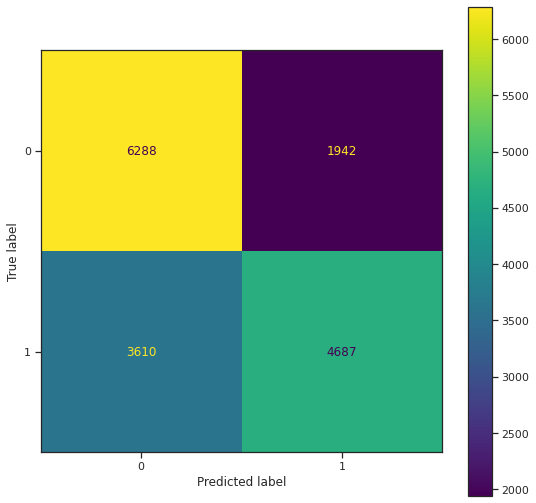

In [130]:
# матрица ошибок
plot_confusion_matrix(booster, features_test, target_test)

Матрица ошибок представляет собой комбинацию прогноза модели и фактического значения.
- модель в 4687 семплах верно определила положилельный класс - True Positive (истинно положительный) и в 6288 случаях верно определила отрицательный класс - True Negative (истинно отрицательный);
- в 1942 случаях модель ошибочно классифицирует семпл как положительный - False Positive (ложноположительный) и в 3610 случаях модель не смогла распознать положительный класс и присвоила отрицательный - False Negative (ложноотрицательный).

In [131]:
# выведу дополнительные метрики классификации
print(classification_report(target_test, booster.predict(features_test), target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.64      0.76      0.69      8230
     Class 1       0.71      0.56      0.63      8297

    accuracy                           0.66     16527
   macro avg       0.67      0.66      0.66     16527
weighted avg       0.67      0.66      0.66     16527



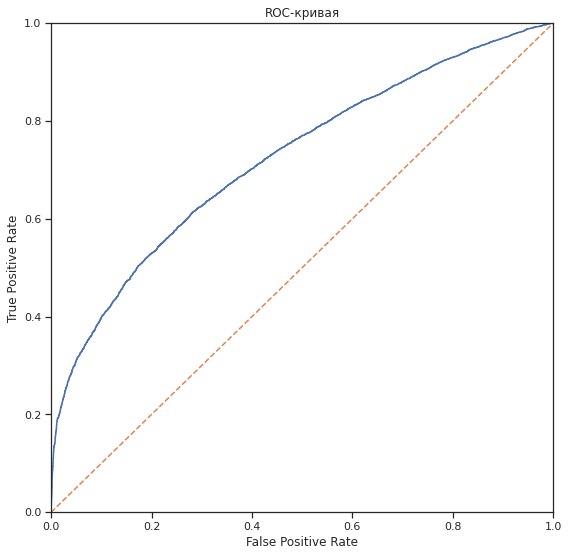

In [132]:
# построение ROC-кривой
probabilities_test = booster.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [133]:
roc_auc_score(target_test, probabilities_one_test)

0.7232985732740069

## Анализ важности факторов ДТП

### Features importance

Чтобы посмотреть какие признаки влияют на обучение модели выведу градацию признаков по важности:

In [134]:
def print_features_importance(model, column_names):
    feats = {}
    for feature, importance in zip(column_names, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='lightgreen')
    plt.xlabel('Importance', fontsize=15, weight = 'bold')
    plt.ylabel('Features', fontsize=15, weight = 'bold')
    plt.title(f'Feature Importance for {model.__class__.__name__}', fontsize=15, weight = 'bold')
    display(plt.show())

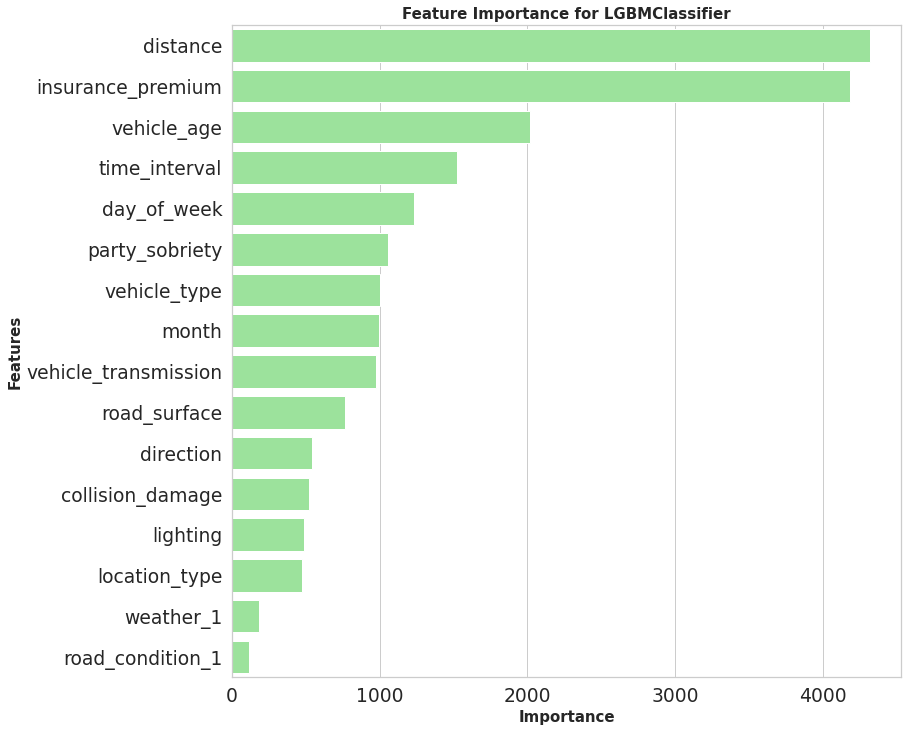

None

In [135]:
print_features_importance(booster, features_train.columns)

- **график зависимости целевой переменной и расстояния до главной дороги:**

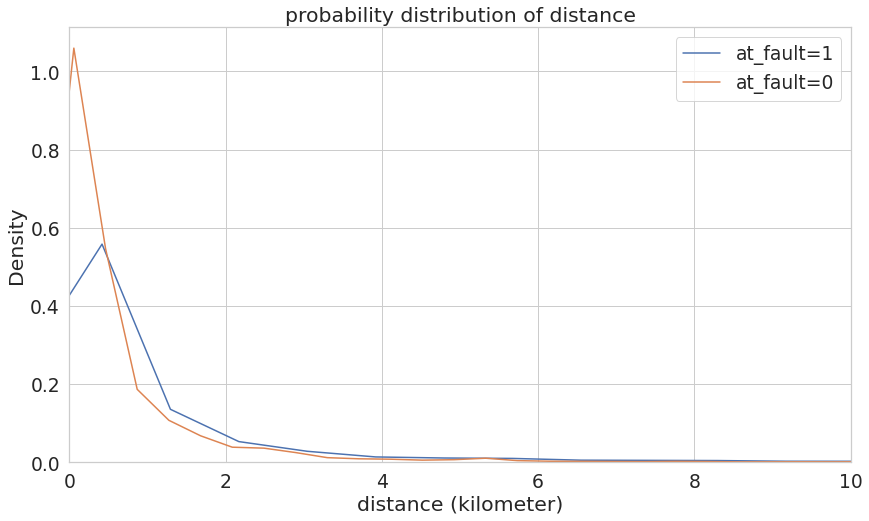

In [136]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.distplot(accident[accident.at_fault==1]['distance'], bins=None, hist=False, label='at_fault=1')
plt.title('probability distribution of distance')
sns.distplot(accident[accident.at_fault==0]['distance'], bins=None, hist=False, label='at_fault=0')
plt.legend()
plt.xlim(0, 10)
plt.xlabel('distance (kilometer)')
plt.show()

**Анализ графика:** большая часть аварий случается рядом с главной дорогой (на расстоянии до 2 км). При наличии бортового компьютера оповещать водителя при приближении к главной дороге - участку, с наиболее интенсивным движением.

- **график зависимости целевой переменной и суммы страховки автомобиля:**

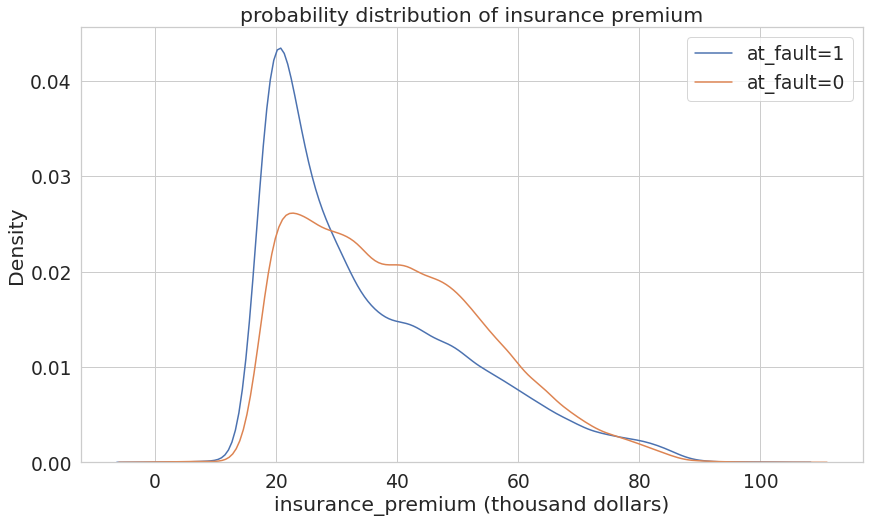

In [137]:
plt.figure(figsize=(14, 8))
sns.distplot(accident[accident.at_fault==1]['insurance_premium'], bins=None, hist=False, label='at_fault=1')
plt.title('probability distribution of insurance premium')
sns.distplot(accident[accident.at_fault==0]['insurance_premium'], bins=None, hist=False, label='at_fault=0')
plt.legend()
plt.xlabel('insurance_premium (thousand dollars)')
plt.show()

***Анализ графика:*** автомобили с дешевой страховкой чаще попадают в аварию. Возможно, стоит повышать стоимость страховки для водителей, которые попадают в ДТП.

- **график зависимости целевой переменной и возраста автомобиля:**

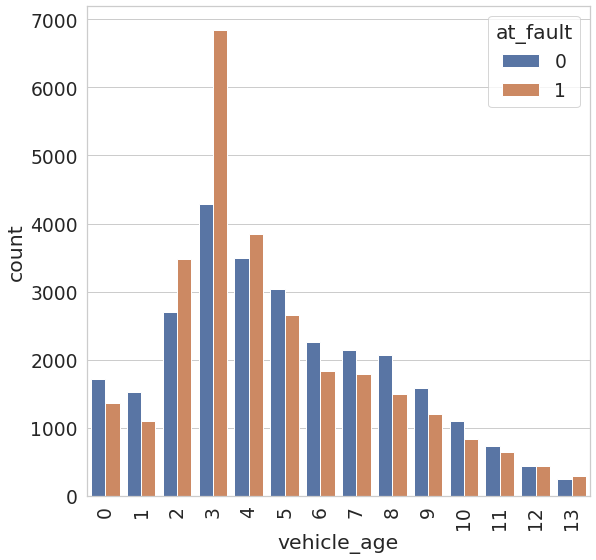

In [138]:
g = sns.countplot(data=accident, x="vehicle_age", hue="at_fault")
g.tick_params(axis='x', rotation=90)

**Анализ графика:** возраст автомобиля также является значимым фактором при вероятности попадания в аварию. И по графику наблюдается, что самый опасный возраст автомобиля - 3 года. Возможно, что машины такого возраста должны чаще проходить техосмотр.

- **график зависимости целевой переменной и временного интервала:**

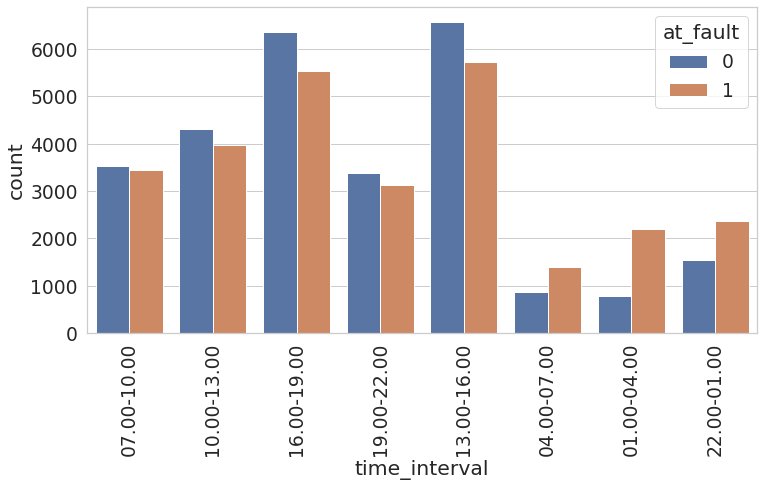

In [139]:
plt.figure(figsize=(12, 6))
g = sns.countplot(data=accident, x="time_interval", hue="at_fault")
g.tick_params(axis='x', rotation=90)

**Анализ графика:** в ночное и вечернее время водители чаще попадают в ДТП.

- **график зависимости целевой переменной и трезвости участника:**

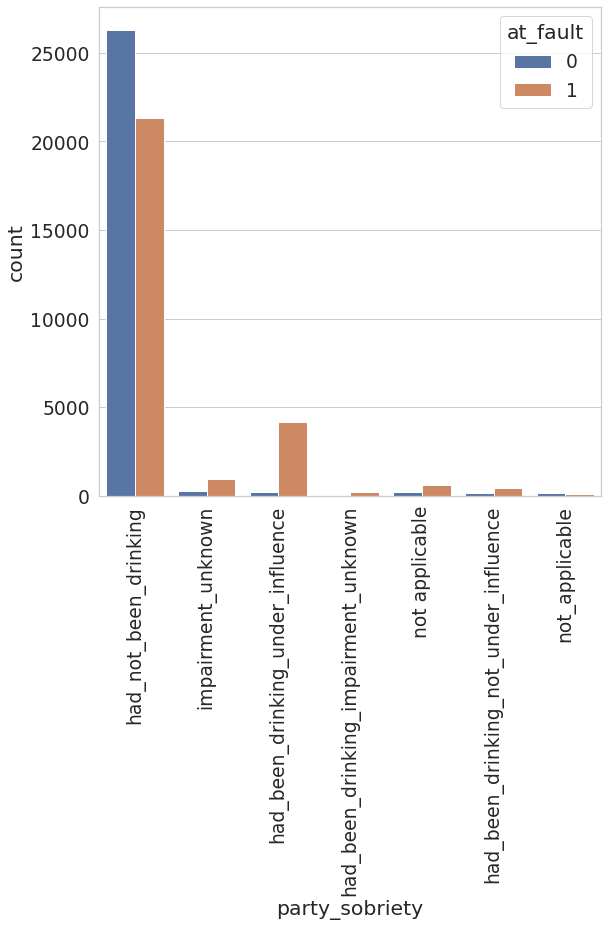

In [140]:
g = sns.countplot(data=accident, x="party_sobriety", hue="at_fault")
g.tick_params(axis='x', rotation=90)

**Анализ графика:** водитель, находящийся в состоянии алкогольного опьянения, почти со 100% вероятностью попадает в ДТП. Как еще можно контролировать этот фактор: оборудовать автомобили боротвым компьютером и перед поездкой сделать обязательным условием прохождение теста на концентрацию и внимание. Такой подход позволит отсекать не только алкогольное, но и другие виды опьянения. 

## Выводы

Лучшей моделью для предсказания вероятности ДТП стала модель **LGBMClassifier** с ключевой метрикой **ROC AUC=0.664 на тестовой выборке** и 0.719 - на обучающей. С помощью optuna я подобрала гиперпараметры для модели: n_estimators=683, max_depth=6, learning_rate=0.009786, objective="binary". Выявила, что значимыми признаками для модели являются расстояние от главной дороги, сумма страховки и возраст автомобиля.

Но я считаю, что значение полученной метрики не достаточно высоко для определения риска ДТП. Возможно, для создания адекватной системы оценки риска при выдаче авто не хватает следующих данных: 
- стаж вождения водителя; 
- профиль вождения;
- дата последнего техосмотра автомобиля;
- наличие пассажиров в транспортном средстве;
- стоимость автомобиля;
- критерий видимости на дороге;
- наличие бортового компьютера или навигатора в машине.